# Import library

In [1]:
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
from enum import Enum
import pandas as pd
import time
from collections import defaultdict

# State class

In [3]:
class State():
    
    
    def __init__(self, price_pct):
        # price_pct : 株価の変化率, アナログ
        self.price_pct = price_pct
        
        
    
            
        

# Action class

In [2]:
class Action(Enum):
    STAY = 0 #買わない
    BUY = 1   #買う

# Environment class

In [3]:
class Environment():
    
    
    def __init__(self, price_chart, pct_chart, n_divide, time=0):
        self.price_chart = price_chart
        self.pct_chart = pct_chart
        self.n_divide = n_divide
        self.time = time
        self.start = time
        
    def reset(self):
        self.time = self.start
        return self.state(self.pct_chart['close'].iloc[self.time])
            
    
    def actions(self):
        return [Action.STAY, Action.BUY]
    
    
    def state(self, price_pct):#アナログ変化率をインデックス化
        list_ = sorted(self.pct_chart['close'].tolist())
        sride = len(list_)//self.n_divide
        
        
        for i in range(self.n_divide):
            if list_[i*sride] <= price_pct < list_[(i+1)*sride]:
                return i
        return i+1

            
    
    def reward_func(self):
        if self.time+1>=len(self.price_chart):
            return 0, True
        else:
            return self.price_chart['close'].iloc[self.time+1]-self.price_chart['open'].iloc[self.time+1], False
    
    
    def step(self, action):
        done=False
        
        
        if self.time+1>=len(self.pct_chart):
            return None, 0, True
        
        
        price_pct = self.pct_chart['close'].iloc[self.time+1]
        next_state = self.state(price_pct)
        self.time += 1
        
        
        if action==Action.STAY:#STAY
            reward=0
        else:
            reward, done =self.reward_func()
            
            
        return next_state, reward, done
        
        
        
    
    

# QLAgent class

In [4]:
class QLAgent():
    
    
    def __init__(self, epsilon):
        self.epsilon = epsilon
        self.Q = {}
        
        
    def policy(self, s, actions):
        if np.random.random() < self.epsilon:
            return np.random.randint(len(actions))
        else:
            if s in self.Q and sum(self.Q[s])!=0:
                return np.argmax(self.Q[s])
            else:
                return np.random.randint(len(actions))

# MonteCarlo Agent class

In [47]:
class MonteCarloAgent(QLAgent):
    
    
    def __init__(self, episode_count=100, epsilon=0.1):
        super().__init__(epsilon)
        self.episode_count = episode_count
        
        
    def learn(self, env,  gamma=0.9):
        actions = env.actions()
        self.Q = defaultdict(lambda: [0] * len(actions))
        N = defaultdict(lambda: [0] * len(actions))
        reward_episode = []
        
        
        for e in range(self.episode_count):
            s = env.reset()
            done = False
            experience = []
            reward_log = []
#             print("-----------------------")
#             print("episode :",e)
           
            while not done:
                a = self.policy(s, actions)
                action = actions[a]
                n_state, reward, done = env.step(action)
                experience.append({"state":s,"action":a,"reward":reward})
                s = n_state
                reward_log.append(reward)
              
            
            reward_episode.append(sum(reward_log))
#             print("Total rewards in 1 episode :",reward_episode[-1])
            for i, x in enumerate(experience):
                s, a = x["state"], x["action"]
                
                
                G, t = 0, 0
                for j in range(i, len(experience)):
                    G += math.pow(gamma, t)*experience[j]["reward"]
                    t+=1
                    
                    
                N[s][a] += 1
                alpha = 1 / N[s][a]
                self.Q[s][a] += alpha * (G - self.Q[s][a])
        print("reward graph")  
        plt.plot(reward_episode)
        plt.show()
        
        
                
    def reward_mean(self, reward_log):
        reward_log = np.array(reward_log)
        return np.mean(reward_log)
    
    
    def estimate(self, env):
        actions = env.actions()
        reward_episode = []
        done = False
        s = env.reset()
        profit = 0
        
        
        while not done:
            a = self.policy(s, actions)
            action = actions[a]
            n_state, reward, done = env.step(action)
            s = n_state
            profit += reward
            reward_episode.append(profit)
            
            
        print("reward graph")  
        print("Total reward :",reward_episode[-1])
        plt.plot(reward_episode)
        plt.show()

# Temporal Difference Agent class

In [28]:
class TemporalDifferenceAgent(QLAgent):
    
    
    def __init__(self, episode_count=100, epsilon=0.1):
        super().__init__(epsilon)
        self.episode_count = episode_count
        
        
    def learn(self, env, learning_rate=0.1, gamma=0.9):
        actions = env.actions()
        self.Q = defaultdict(lambda: [0] * len(actions))
        reward_episode = []
        
        
        for e in range(self.episode_count):
            s = env.reset()
            done = False
            experience = []
            reward_log = []
#             print("-----------------------")
#             print("episode :",e)
           
            
            while not done:
                a = self.policy(s, actions)
                action = actions[a]
                n_state, reward, done = env.step(action)

                
                gain = reward + gamma*max(self.Q[n_state]) 
                estimated = self.Q[s][a]
                self.Q[s][a] += learning_rate * (gain - estimated)
                s = n_state
                reward_log.append(reward)
                    
            
            reward_episode.append(sum(reward_log))
#             print("Total rewards in 1 episode :",reward_episode[-1])

        
        print("reward graph")  
        plt.plot(reward_episode)
        plt.show()
        
        
                
    def reward_mean(self, reward_log):
        reward_log = np.array(reward_log)
        return np.mean(reward_log)
    
    
    def estimate(self, env):
        actions = env.actions()
        reward_episode = []
        profit = 0
        done = False
        s = env.reset()

        
        
        while not done:
            a = self.policy(s, actions)
            action = actions[a]
            n_state, reward, done = env.step(action)
            s = n_state
            profit += reward
            reward_episode.append(profit)
            
            
        print("reward graph")  
        print("Total reward :",reward_episode[-1])
        
        plt.plot(reward_episode)
        plt.show()

# load df

In [7]:
def load_df(path_):

    
    FILE = glob.glob(path_)
    df = pd.read_csv(FILE[0])
    df = df.rename(columns={df.columns[0]:'nan',df.columns[1]:'nan',df.columns[2]:'nan',\
                                df.columns[3]:'day',df.columns[4]:'nan',df.columns[5]:'open',\
                                df.columns[6]:'high',df.columns[7]:'low',df.columns[8]:'close',\
                                   df.columns[9]:'nan',})

    df = df.drop('nan',axis=1)
    df = df.drop(df.index[0])
    df['day'] = pd.to_datetime(df['day'],format='%Y/%m/%d')
    df.set_index('day',inplace=True)
    
    
    return df.astype(float)



# train func

In [40]:
path_ = '/Users/rince/Desktop/StockPriceData/Stock_index/NFNK225_10years.csv'
price_chart = load_df(path_)
pct_chart = price_chart.pct_change()

In [34]:
pct_chart = pct_chart.iloc[-250:]
price_chart = price_chart.iloc[-250:]

e  100
reward graph


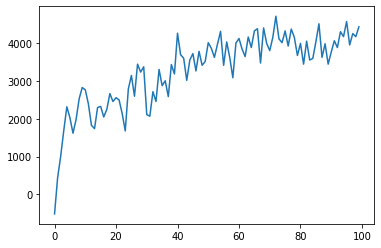

reward graph
Total reward : 70.0


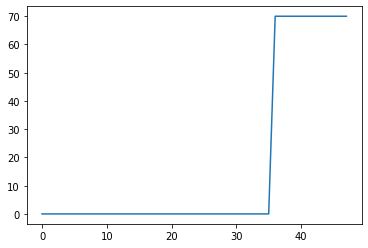

reward graph


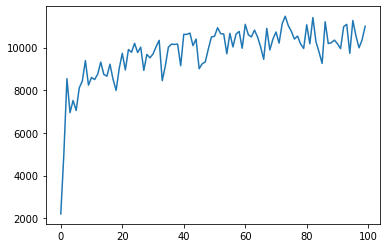

reward graph
Total reward : 480.0


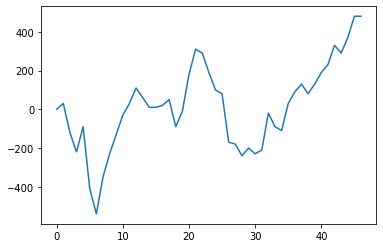

reward graph


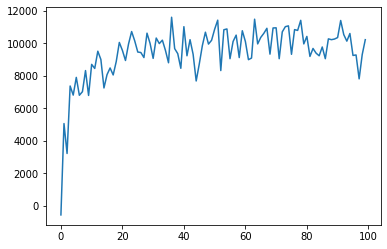

reward graph
Total reward : 80.0


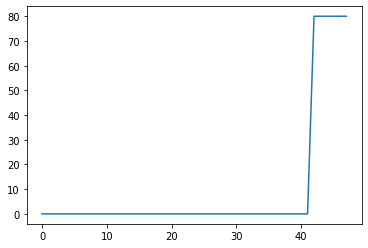

reward graph


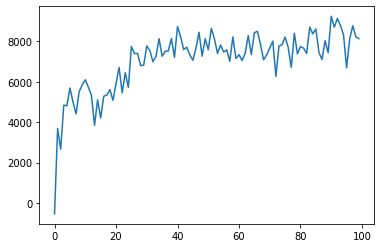

reward graph
Total reward : -250.0


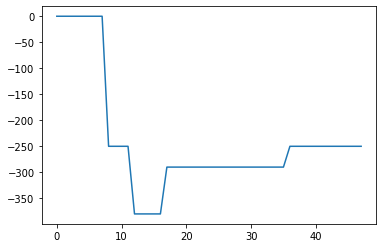

reward graph


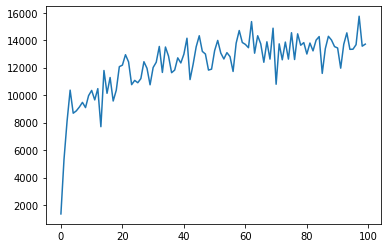

reward graph
Total reward : -870.0


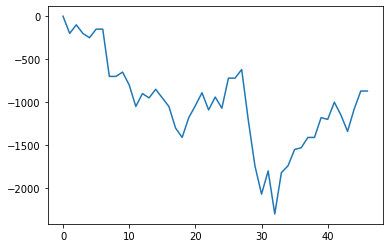

e  500
reward graph


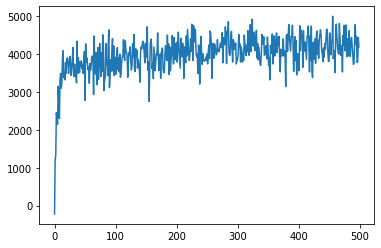

reward graph
Total reward : -110.0


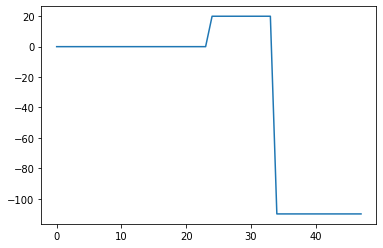

reward graph


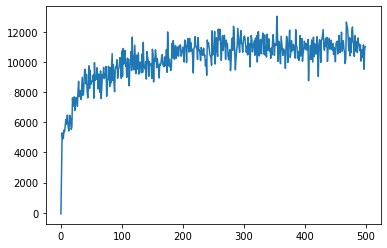

reward graph
Total reward : 560.0


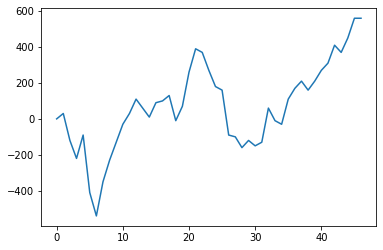

reward graph


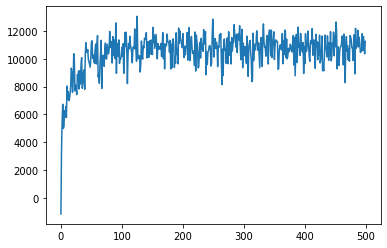

reward graph
Total reward : 0


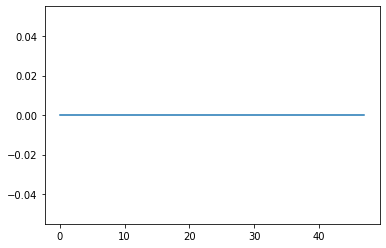

reward graph


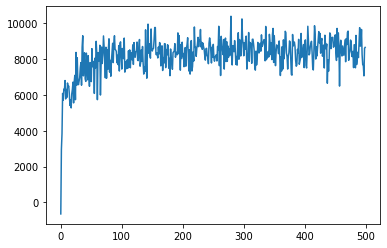

reward graph
Total reward : 110.0


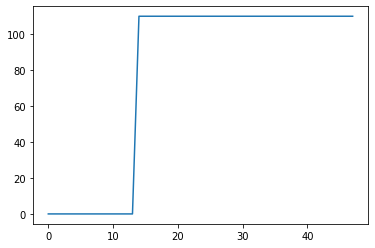

reward graph


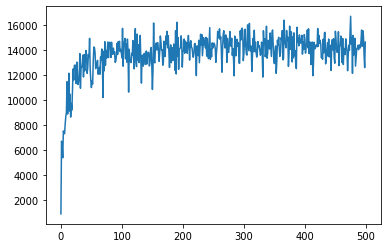

reward graph
Total reward : -780.0


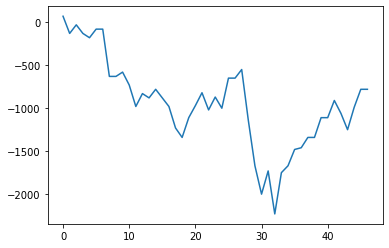

e  1000
reward graph


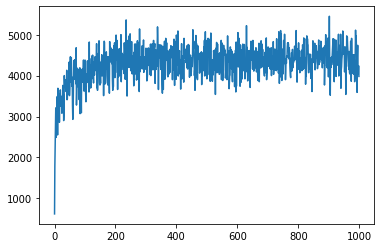

reward graph
Total reward : 10.0


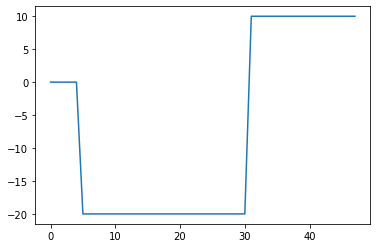

reward graph


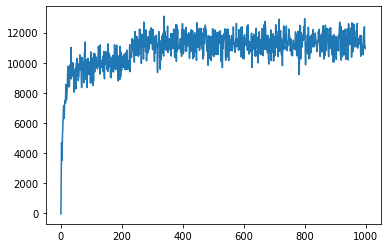

reward graph
Total reward : 510.0


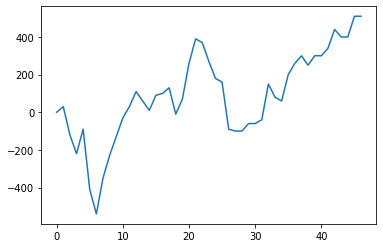

reward graph


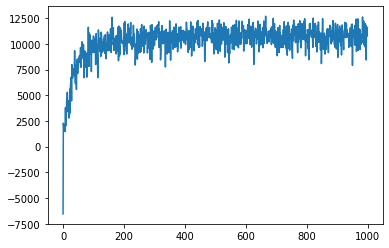

reward graph
Total reward : 10.0


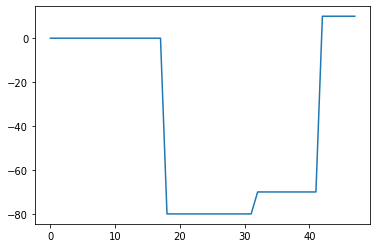

reward graph


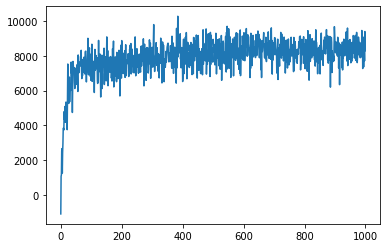

reward graph
Total reward : 30.0


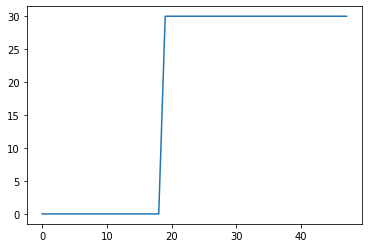

reward graph


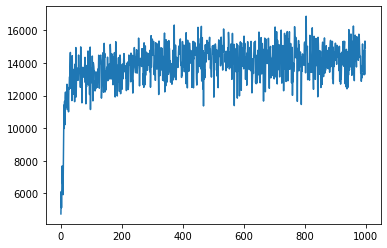

reward graph
Total reward : -670.0


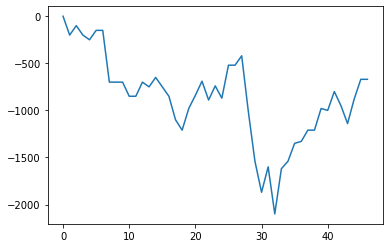

In [49]:
# def train():
# #     agent = TemporalDifferenceAgent(epsilon=0.1)
n = 5
test_rate = 0.9
length = len(price_chart)
width = length//n


for e in [100,500,1000]:
    print("e ",e)
#     agent = MonteCarloAgent(episode_count=e,epsilon=0.1)
    for i in range(n):
        start1 = i*width+1
        end1 = start1 +  int(test_rate * width)
        start2 = end1
        end2 = (i+1)*width
        
        
        env_train = Environment(price_chart.iloc[start1 : end1], pct_chart.iloc[start1:end1], n_divide=99)
        env_test = Environment(price_chart.iloc[start2 : end2], pct_chart.iloc[start2 : end2], n_divide=99)
        
        agent = MonteCarloAgent(episode_count=e,epsilon=0.1)
#         agent = TemporalDifferenceAgent(episode_count=e,epsilon=0.1)
        agent.learn(env_train)        
        agent.estimate(env_test)
        print("===============================")
#     print(agent.Q)

-----------------------
episode : 0
Total rewards in 1 episode : 170.0
-----------------------
episode : 1
Total rewards in 1 episode : 12540.0
-----------------------
episode : 2
Total rewards in 1 episode : 13200.0
-----------------------
episode : 3
Total rewards in 1 episode : 12990.0
-----------------------
episode : 4
Total rewards in 1 episode : 14390.0
-----------------------
episode : 5
Total rewards in 1 episode : 15660.0
-----------------------
episode : 6
Total rewards in 1 episode : 14450.0
-----------------------
episode : 7
Total rewards in 1 episode : 18110.0
-----------------------
episode : 8
Total rewards in 1 episode : 15630.0
-----------------------
episode : 9
Total rewards in 1 episode : 15650.0
-----------------------
episode : 10
Total rewards in 1 episode : 15260.0
-----------------------
episode : 11
Total rewards in 1 episode : 14450.0
-----------------------
episode : 12
Total rewards in 1 episode : 14570.0
-----------------------
episode : 13
Total rewards

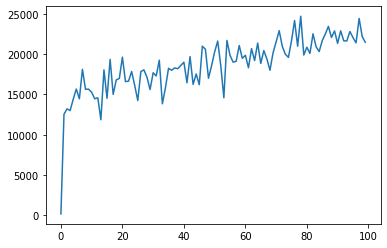

UnboundLocalError: local variable 's' referenced before assignment

In [15]:
start_time = time.time()
train()
print("calc time :",time.time()-start_time)

In [35]:
pct_chart

,open,high,low,close
day,,,,
2020-06-01,0.005732,0.009632,0.008857,0.007912
2020-06-02,0.011399,0.010841,0.010097,0.013956
2020-06-03,0.026441,0.018447,0.015645,0.015054
2020-06-04,0.006757,0.005476,0.001712,0.000000
2020-06-05,-0.012164,-0.003770,0.002563,0.007203
...,...,...,...,...
2021-06-01,0.000000,-0.001653,-0.006361,-0.001336
2021-06-02,-0.010299,-0.003311,-0.001685,0.004681
2021-06-03,0.006714,0.004983,0.010462,0.004992
